# Create classification model(s)
- start with the "food.csv"
- tfidf vectorizer & classification models
- combining text fields except for "food_group" and/or "food_subgroup"

In [35]:
# import pprint
import importlib
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

import modeling

In [ ]:
importlib.reload(modeling)

#### pull data & basic cleanup
- get rid of columns that I won't use
- remove the 47 rows that are missing "description" data

In [2]:
food = pd.read_csv("data/foodb_2020_04_07_csv/Food.csv")
# food.head(3)

In [3]:
rows = food.shape[0]
print(f"rows: {rows}")
print(f"columns: {food.columns}")

rows: 992
columns: Index(['id', 'name', 'name_scientific', 'description', 'itis_id',
       'wikipedia_id', 'picture_file_name', 'picture_content_type',
       'picture_file_size', 'picture_updated_at', 'legacy_id', 'food_group',
       'food_subgroup', 'food_type', 'created_at', 'updated_at', 'creator_id',
       'updater_id', 'export_to_afcdb', 'category', 'ncbi_taxonomy_id',
       'export_to_foodb', 'public_id'],
      dtype='object')


In [4]:
# getting rid of columns I don"t care about
drop_columns = ["id", "itis_id", "picture_file_name", "picture_content_type", "picture_file_size", "picture_updated_at", "legacy_id", "created_at", "updated_at", "creator_id",
       "updater_id", "export_to_afcdb", "category", "ncbi_taxonomy_id", "export_to_foodb", "public_id", "food_type"]

print(f"keeping columns: {set(food.columns).difference(set(drop_columns))}")

keeping columns: {'wikipedia_id', 'name', 'description', 'food_group', 'food_subgroup', 'name_scientific'}


In [5]:
food.drop(columns=drop_columns, inplace=True)
food.head(3)

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup
0,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs
1,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,Savoy cabbage,Vegetables,Cabbages
2,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,Tilia tomentosa,Herbs and Spices,Herbs


In [6]:
null_count = {}
for col in food.columns:
    null_count[col] = round(food[col].isna().sum()/rows, 4)
    
null_count

{'name': 0.0,
 'name_scientific': 0.3196,
 'description': 0.0474,
 'wikipedia_id': 0.1401,
 'food_group': 0.003,
 'food_subgroup': 0.0071}

In [7]:
food.dropna(subset=["description"], inplace=True)
food.shape

(945, 6)

---
## EDA on "food_group" and "food_subgroup"

In [8]:
print(f"nulls in 'food_subgroup': {food["food_subgroup"].isna().sum()}")
print(f"nulls in 'food_group': {food["food_group"].isna().sum()}")

nulls in 'food_subgroup': 2
nulls in 'food_group': 2


In [9]:
food.dropna(subset=["food_group", "food_subgroup"], inplace=True)
food.shape

(943, 6)

In [10]:
food["food_group"].value_counts(normalize=True)

food_group
Aquatic foods                  0.179215
Fruits                         0.161188
Vegetables                     0.144221
Herbs and Spices               0.132556
Dishes                         0.049841
Cereals and cereal products    0.048780
Milk and milk products         0.038176
Beverages                      0.033934
Animal foods                   0.030753
Confectioneries                0.030753
Pulses                         0.029692
Nuts                           0.028632
Baking goods                   0.027572
Gourds                         0.020148
Soy                            0.007423
Teas                           0.007423
Snack foods                    0.007423
Fats and oils                  0.007423
Cocoa and cocoa products       0.006363
Coffee and coffee products     0.004242
Eggs                           0.002121
Baby foods                     0.001060
Herbs and spices               0.001060
Name: proportion, dtype: float64

In [11]:
food["food_group"].unique()

array(['Herbs and Spices', 'Vegetables', 'Fruits', 'Nuts',
       'Cereals and cereal products', 'Pulses', 'Teas', 'Gourds',
       'Coffee and coffee products', 'Soy', 'Cocoa and cocoa products',
       'Beverages', 'Aquatic foods', 'Animal foods',
       'Milk and milk products', 'Eggs', 'Confectioneries',
       'Baking goods', 'Dishes', 'Snack foods', 'Baby foods',
       'Fats and oils', 'Herbs and spices'], dtype=object)

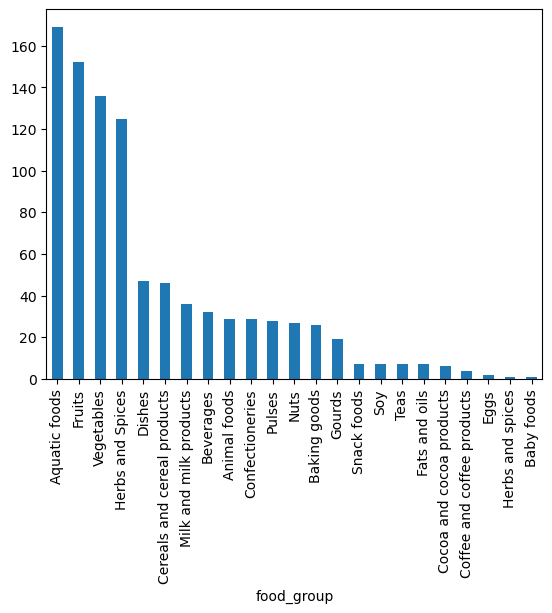

In [12]:
food.groupby("food_group").size().sort_values(ascending=False).plot(kind="bar");

In [13]:
food["food_group"] = food["food_group"].str.replace("Herbs and spices", "Herbs and Spices")
food["food_group"].unique()

array(['Herbs and Spices', 'Vegetables', 'Fruits', 'Nuts',
       'Cereals and cereal products', 'Pulses', 'Teas', 'Gourds',
       'Coffee and coffee products', 'Soy', 'Cocoa and cocoa products',
       'Beverages', 'Aquatic foods', 'Animal foods',
       'Milk and milk products', 'Eggs', 'Confectioneries',
       'Baking goods', 'Dishes', 'Snack foods', 'Baby foods',
       'Fats and oils'], dtype=object)

In [14]:
# "Dishes"??? what kind of label is that
food.loc[food["food_group"] == "Dishes"].head(10)

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup
636,Pizza,NaN,Pizza is an oven-baked flat bread typically to...,Pizza,Dishes,Other dishes
651,Sausage,NaN,Sausage is a food usually made from ground mea...,Sausage,Dishes,Ground meat
652,Meatball,NaN,Meatball is made from an amount of ground meat...,Meatball,Dishes,Ground meat
654,Pate,NaN,Pâté is a mixture of ground meat and fat mince...,Pâté,Dishes,Ground meat
668,Dumpling,NaN,Dumplings are cooked balls of dough. They are ...,Dumpling,Dishes,Other dishes
669,Soup,NaN,Soup is a generally warm food that is made by ...,Soup,Dishes,Other dishes
703,Burrito,NaN,"A burrito, or taco de harina, is a type of Mex...",Burrito,Dishes,Tex-Mex cuisine
704,Hamburger,NaN,A hamburger (also called a hamburger sandwich ...,Hamburger,Dishes,Sandwiches
705,Baked beans,NaN,"Baked beans is a dish containing beans, someti...",Baked_beans,Dishes,Other dishes
706,Chili,NaN,Chili con carne (often known simply as chili) ...,Chili_con_carne,Dishes,Tex-Mex cuisine


In [15]:
food.loc[food["food_group"] == "Baby foods"].head()

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup
667,Baby food,NaN,"Baby food is any soft, easily consumed food, o...",Baby food,Baby foods,Baby foods


In [29]:
len(food["food_group"].unique())

22

In [16]:
len(food["food_subgroup"].unique())

112

In [17]:
fishy = food.loc[food["food_group"] == "Aquatic foods"]
fishy["food_subgroup"].value_counts()

food_subgroup
Fishes                 112
Mollusks                18
Crustaceans             12
Seaweed                  9
Pinnipeds                6
Other aquatic foods      5
Cetaceans                3
Amphibians               1
Fish products            1
Roe                      1
Bivalvia                 1
Name: count, dtype: int64

---
## prepare data for modeling
- combine text columns, except for "food_group"

In [18]:
text_cols = list(food.columns)
text_cols.remove("food_group")
text_cols

['name', 'name_scientific', 'description', 'wikipedia_id', 'food_subgroup']

In [19]:
food.fillna("", inplace=True)

food["all_text"] = food[text_cols].apply(" ".join, axis=1)
food["all_text"].head(3)

0    Angelica Angelica keiskei Angelica is a genus ...
1    Savoy cabbage Brassica oleracea var. sabauda S...
2    Silver linden Tilia argentea Tilia tomentosa (...
Name: all_text, dtype: object

---
- wouldn't it be cool if I could do the transformations of both the data & the target in a pipeline?
- sadly, this did not work; I tried:
    - passing the whole df to `test_pipe.fit`, without doing a train/test split
    - passing the columns, no train/test split
    - doing the train/test split & passing `X_train` and `y_train`

In [30]:
# inspired by this article: https://towardsdatascience.com/step-by-step-tutorial-of-sci-kit-learn-pipeline-62402d5629b6

data_transformer = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(stop_words="english"))
])

target_transformer = Pipeline(steps=[
    ("ord_encoder", OrdinalEncoder(categories=food["food_group"].unique()))
])

preprocessor = ColumnTransformer(transformers=[
    ("data", data_transformer, "all_text"),
    ("target", target_transformer, "food_group")
])

test_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000))
])

In [26]:
X = food.drop(columns=["food_group"])
y = food["food_group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# lr_model = test_pipe.fit(X_train, y_train)

---
### transform target
- there are 22 labels in the "food_group" column
- trying a few different ways to encode those labels:
    - label encoder: just assigns a numerical value to each label
    - target encoder: calculates the probability of each label occurring
    - OHE: sparse array of binary values
    - get_dummies: 
- since some of the labels have very few instances in the data, I'm using cross-validation to evaluate thse encoders rather than train/test split

In [36]:
label_encoder = LabelEncoder()
label_enc_y = label_encoder.fit_transform(food["food_group"])

In [38]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_x = tfidf.fit_transform(food["all_text"])

lr = LogisticRegression(max_iter=1000)
cross_val_score(lr, tfidf_x, label_enc_y, cv=5).mean()

/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.6744455701902511

In [ ]:
# defining params for the different models
pipe_params = {
    "tfidf__max_features": [None, 250, 300],
    "tfidf__min_df": [1, 0.01, 0.05],
    "tfidf__max_df": [1.0, 0.98, 0.95, 0.9],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "lr__solver": ["lbfgs", "liblinear"],
    "lr__C": [1.0, 0.1, 10],
    "multi__alpha": [1.0, 0.5],
    "rfc__n_estimators": [100, 50, 150],
    "rfc__max_depth": [None, 5, 10],
    "rfc__min_samples_split": [2, 5, 7],
    "rfc__min_samples_leaf": [1, 2, 3],
    "rfc__bootstrap": [True, False]
}

In [ ]:
# and the pipelines
lr_pipe = [("tfidf", TfidfVectorizer(stop_words="english")), ("lr", LogisticRegression(max_iter=1000))]
multi_pipe = [("tfidf", TfidfVectorizer(stop_words="english")), ("multi", )]
